In [2]:
from time import time

import pandas as pd
from utilsforecast.plotting import plot_series

# model
from prophet import Prophet
import lightgbm as lgb
from mlforecast import MLForecast
# feature engine
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
# model training, forecasting, evaluation
from mlforecast.utils import PredictionIntervals
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape, smape

# params

In [11]:
freq = "h"
horizon = 24
n_windows = 7

# data

df.head(): 
         unique_id                  ds        y
0  PJM_Load_hourly 1998-04-01 01:00:00  22259.0
1  PJM_Load_hourly 1998-04-01 02:00:00  21244.0
2  PJM_Load_hourly 1998-04-01 03:00:00  20651.0
3  PJM_Load_hourly 1998-04-01 04:00:00  20421.0
4  PJM_Load_hourly 1998-04-01 05:00:00  20713.0

df.tail(): 
             unique_id                  ds        y
32891  PJM_Load_hourly 2001-12-31 20:00:00  36392.0
32892  PJM_Load_hourly 2001-12-31 21:00:00  35082.0
32893  PJM_Load_hourly 2001-12-31 22:00:00  33890.0
32894  PJM_Load_hourly 2001-12-31 23:00:00  32590.0
32895  PJM_Load_hourly 2002-01-01 00:00:00  31569.0

df.shape: (32896, 3)


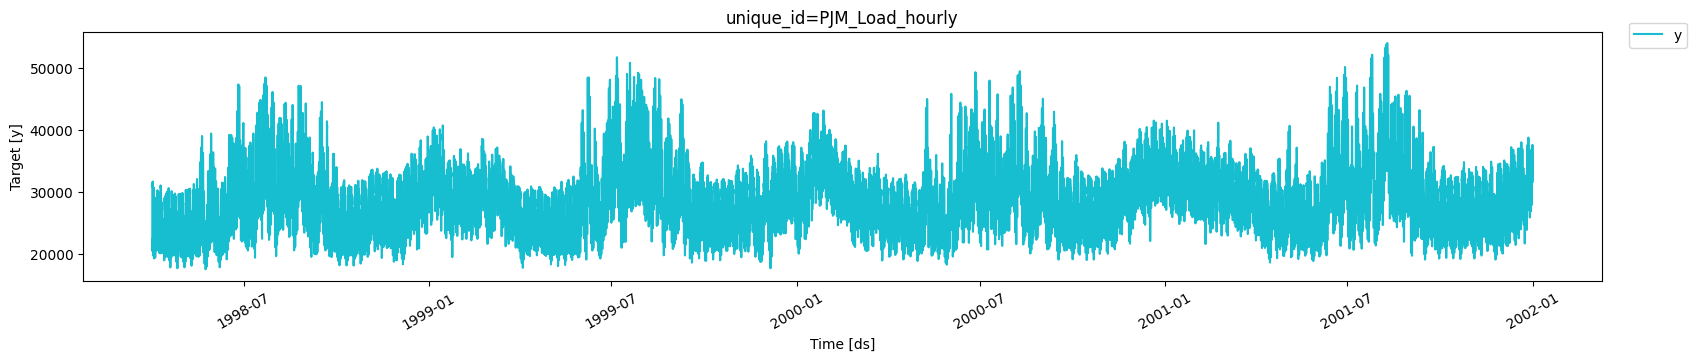

In [8]:
def load_data():
    # data path
    data_url = "https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv"
    # data read
    df = pd.read_csv(data_url, parse_dates = ["Datetime"])
    # data rename
    df.columns = ["ds", "y"]
    # add unique_id col
    df.insert(0, "unique_id", "PJM_Load_hourly")
    # ds transform
    df["ds"] = pd.to_datetime(df["ds"])
    # sort
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop = True)
    
    return df

df = load_data()
print(f"df.head(): \n{df.head()}")
print()
print(f"df.tail(): \n{df.tail()}")
print()
print(f"df.shape: {df.shape}")

fig = plot_series(df)
fig

# data split

In [12]:
threshold_time = df["ds"].max() - pd.Timedelta(hours = horizon)

# train dataset
df_train = df.loc[df["ds"] <= threshold_time, :]

# test dataset
df_last_24_hours = df.loc[df["ds"] > threshold_time, :]

print(f"df_train.shape: {df_train.shape}")
print(f"df_last_24_hours.shape: {df_last_24_hours.shape}")

df_train.shape: (32872, 3)
df_last_24_hours.shape: (24, 3)


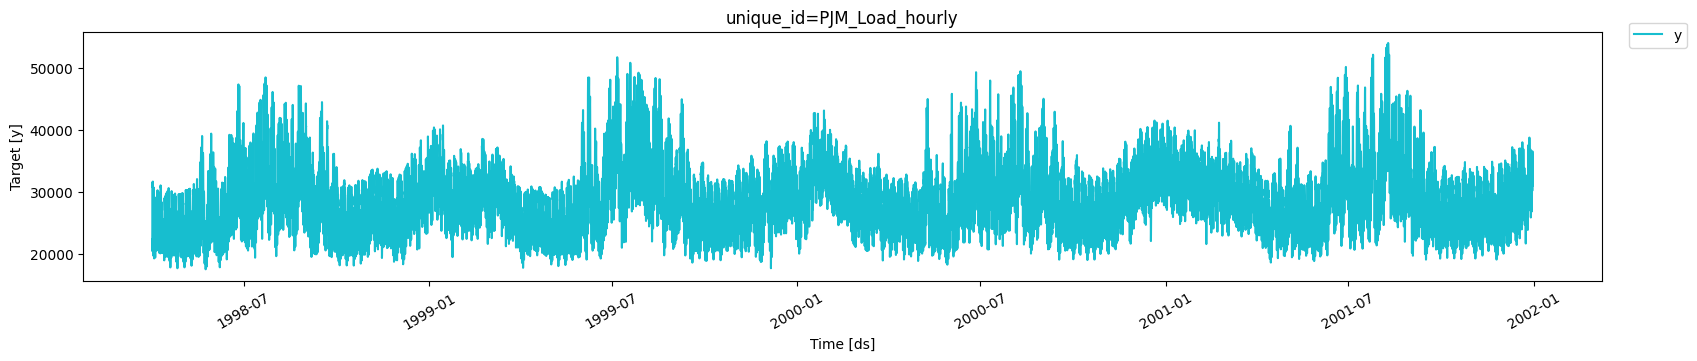

In [13]:
fig = plot_series(df_train)
fig

# Prophet

## model

In [14]:
prophet = Prophet(interval_width = 0.9)

## model training

In [15]:
prophet.fit(df_train)

23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing


## model predict

In [54]:
future = prophet.make_future_dataframe(
    periods=horizon,
    freq=freq,
    include_history=False,
)
forecast_prophet = prophet.predict(future)
forecast_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-12-31 01:00:00,29382.773870,20664.253388,30572.101706,29382.773870,29382.773870,-4118.205158,-4118.205158,-4118.205158,-4253.127092,-4253.127092,-4253.127092,-1142.032389,-1142.032389,-1142.032389,1276.954323,1276.954323,1276.954323,0.0,0.0,0.0,25264.568712
1,2001-12-31 02:00:00,29382.559065,18969.008940,28967.704887,29382.559065,29382.559065,-5411.590316,-5411.590316,-5411.590316,-5728.576290,-5728.576290,-5728.576290,-960.016186,-960.016186,-960.016186,1277.002160,1277.002160,1277.002160,0.0,0.0,0.0,23970.968749
2,2001-12-31 03:00:00,29382.344261,18409.884501,27916.414699,29382.344261,29382.344261,-6087.389458,-6087.389458,-6087.389458,-6585.055597,-6585.055597,-6585.055597,-779.384056,-779.384056,-779.384056,1277.050196,1277.050196,1277.050196,0.0,0.0,0.0,23294.954803
3,2001-12-31 04:00:00,29382.129456,18497.573625,28473.229380,29382.129456,29382.129456,-6079.467811,-6079.467811,-6079.467811,-6755.443663,-6755.443663,-6755.443663,-601.122687,-601.122687,-601.122687,1277.098539,1277.098539,1277.098539,0.0,0.0,0.0,23302.661645
4,2001-12-31 05:00:00,29381.914651,19069.623076,28877.723611,29381.914651,29381.914651,-5304.679951,-5304.679951,-5304.679951,-6155.651377,-6155.651377,-6155.651377,-426.175873,-426.175873,-426.175873,1277.147299,1277.147299,1277.147299,0.0,0.0,0.0,24077.234700
5,2001-12-31 06:00:00,29381.699847,20625.524902,30437.866550,29381.699847,29381.699847,-3755.393009,-3755.393009,-3755.393009,-4777.152680,-4777.152680,-4777.152680,-255.436916,-255.436916,-255.436916,1277.196587,1277.196587,1277.196587,0.0,0.0,0.0,25626.306838
6,2001-12-31 07:00:00,29381.485042,22767.073976,32741.870082,29381.485042,29381.485042,-1640.435605,-1640.435605,-1640.435605,-2827.940493,-2827.940493,-2827.940493,-89.741623,-89.741623,-89.741623,1277.246511,1277.246511,1277.246511,0.0,0.0,0.0,27741.049437
7,2001-12-31 08:00:00,29381.270237,25138.752859,34889.282887,29381.270237,29381.270237,602.077413,602.077413,602.077413,-745.357772,-745.357772,-745.357772,70.138005,70.138005,70.138005,1277.297180,1277.297180,1277.297180,0.0,0.0,0.0,29983.347651
8,2001-12-31 09:00:00,29381.055433,27048.418242,36590.203233,29381.055433,29381.055433,2486.523854,2486.523854,2486.523854,985.675804,985.675804,985.675804,223.499348,223.499348,223.499348,1277.348702,1277.348702,1277.348702,0.0,0.0,0.0,31867.579287
9,2001-12-31 10:00:00,29380.840628,28358.014345,37948.219852,29380.840628,29380.840628,3731.616466,3731.616466,3731.616466,2084.501328,2084.501328,2084.501328,369.713952,369.713952,369.713952,1277.401186,1277.401186,1277.401186,0.0,0.0,0.0,33112.457094


In [55]:
forecast_prophet = forecast_prophet[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_prophet.columns = ["ds", "Prophet", "Prophet-lo-90", "Prophet-hi-90"]
forecast_prophet.insert(0, "unique_id", "PJM_Load_hourly")
forecast_prophet

,unique_id,ds,Prophet,Prophet-lo-90,Prophet-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,25264.568712,20664.253388,30572.101706
1,PJM_Load_hourly,2001-12-31 02:00:00,23970.968749,18969.008940,28967.704887
2,PJM_Load_hourly,2001-12-31 03:00:00,23294.954803,18409.884501,27916.414699
3,PJM_Load_hourly,2001-12-31 04:00:00,23302.661645,18497.573625,28473.229380
4,PJM_Load_hourly,2001-12-31 05:00:00,24077.234700,19069.623076,28877.723611
5,PJM_Load_hourly,2001-12-31 06:00:00,25626.306838,20625.524902,30437.866550
6,PJM_Load_hourly,2001-12-31 07:00:00,27741.049437,22767.073976,32741.870082
7,PJM_Load_hourly,2001-12-31 08:00:00,29983.347651,25138.752859,34889.282887
8,PJM_Load_hourly,2001-12-31 09:00:00,31867.579287,27048.418242,36590.203233
9,PJM_Load_hourly,2001-12-31 10:00:00,33112.457094,28358.014345,37948.219852


# LightGBM

## model

In [56]:
mlf = MLForecast(
    models = {
        "lgbm": lgb.LGBMRegressor(verbosity=-1),
    },
    freq=freq,
    lags=[1, 12, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[
        "month", "hour", "dayofweek",
    ],
    target_transforms=[
        Differences([24, 24*7])
    ],
)

## model training

In [57]:
mlf.fit(
    df = df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=horizon)
)

MLForecast(models=[lgbm], freq=h, lag_features=['lag1', 'lag12', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=['month', 'hour', 'dayofweek'], num_threads=1)

## model predict

In [58]:
forecast_lgbm = mlf.predict(h=horizon, level=[90])
forecast_lgbm

,unique_id,ds,lgbm,lgbm-lo-90,lgbm-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,28847.573176,28567.603130,29127.543222
1,PJM_Load_hourly,2001-12-31 02:00:00,27862.589195,27128.839888,28596.338503
2,PJM_Load_hourly,2001-12-31 03:00:00,27044.418960,25688.230426,28400.607493
3,PJM_Load_hourly,2001-12-31 04:00:00,26976.104125,25286.024722,28666.183529
4,PJM_Load_hourly,2001-12-31 05:00:00,26694.246238,25051.548832,28336.943644
5,PJM_Load_hourly,2001-12-31 06:00:00,27582.766829,25965.048327,29200.485330
6,PJM_Load_hourly,2001-12-31 07:00:00,29405.382396,27563.188363,31247.576428
7,PJM_Load_hourly,2001-12-31 08:00:00,30721.271714,29108.838425,32333.705002
8,PJM_Load_hourly,2001-12-31 09:00:00,31726.273459,30296.388795,33156.158122
9,PJM_Load_hourly,2001-12-31 10:00:00,33106.592526,31769.639140,34443.545911


# model evaluation

In [59]:
metrics_comparison = df_last_24_hours \
    .merge(forecast_lgbm, on=["unique_id", "ds"], how="left") \
    .merge(forecast_prophet, on=["unique_id", "ds"], how="left")
metrics_comparison.columns

Index(['unique_id', 'ds', 'y', 'lgbm', 'lgbm-lo-90', 'lgbm-hi-90', 'Prophet',
       'Prophet-lo-90', 'Prophet-hi-90'],
      dtype='object')

In [60]:
metrics_comparison = evaluate(
    df=metrics_comparison,
    metrics=[mae, rmse, mape, smape],
    models=["Prophet", "lgbm"],
)
metrics_comparison.reset_index(drop=True).style.background_gradient(cmap="RdYlGn_r", axis=1)

,unique_id,metric,Prophet,lgbm
0,PJM_Load_hourly,mae,2295.456556,1092.050817
1,PJM_Load_hourly,rmse,2737.694638,1340.422762
2,PJM_Load_hourly,mape,0.074149,0.033600
3,PJM_Load_hourly,smape,0.038871,0.017137


In [61]:
metrics_comparison['improvement'] = metrics_comparison['Prophet'] /  metrics_comparison['lgbm']
metrics_comparison['improvement'] = metrics_comparison['improvement'].apply(lambda x: f'{x:.2f}')
metrics_comparison.set_index('metric')[['improvement']]

,improvement
metric,
mae,2.10
rmse,2.04
mape,2.21
smape,2.27
